In [1]:
from IPython.core.display import display, HTML # for some notebook formatting.
import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string

from ast import literal_eval

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import SARunner, GARunner, NNGSRunner

from mlrose_hiive.opt_probs.discrete_opt import DiscreteOpt

from GraphGenusFitness import GraphGenusFitness
from GraphGenusOpt import GraphGenusOpt
from GraphGenusGenerator import GraphGenusGenerator

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

/var/folders/r6/n5pyldc55f96f_ptljhwj4240000gn/T/ipykernel_3664/50844019.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML # for some notebook formatting.


In [2]:
import numpy as np
import networkx as nx
from mlrose_hiive import DiscreteOpt, CustomFitness

class GraphGenusGenerator:
    @staticmethod
    def generate(seed, number_of_nodes=20, max_connections_per_node=4, complete_graph=False):
        np.random.seed(seed)
        
        if complete_graph:
            # Generate a complete graph
            g = nx.complete_graph(number_of_nodes)
        else:
            # All nodes have to be connected, somehow.
            node_connection_counts = 1 + np.random.randint(max_connections_per_node, size=number_of_nodes)

            node_connections = {}
            nodes = range(number_of_nodes)
            for n in nodes:
                all_other_valid_nodes = [o for o in nodes if (o != n and (o not in node_connections or
                                                                          n not in node_connections[o]))]
                count = min(node_connection_counts[n], len(all_other_valid_nodes))
                other_nodes = sorted(np.random.choice(all_other_valid_nodes, count, replace=False))
                node_connections[n] = [(n, o) for o in other_nodes]

            # Check connectivity
            g = nx.Graph()
            g.add_edges_from([x for y in node_connections.values() for x in y])

            for n in nodes:
                cannot_reach = [(n, o) if n < o else (o, n) for o in nodes if o not in nx.bfs_tree(g, n).nodes()]
                for s, f in cannot_reach:
                    g.add_edge(s, f)
                    check_reach = len([(n, o) if n < o else (o, n) for o in nodes if o not in nx.bfs_tree(g, n).nodes()])
                    if check_reach == 0:
                        break

        adjacency_list = {node: list(g.neighbors(node)) for node in g.nodes()}
        problem = GraphGenusOpt(length=number_of_nodes, fitness_fn=GraphGenusFitness(adjacency_list=adjacency_list), maximize=False, adjacency_list=g)
        return problem


In [3]:
class GraphGenusFitness:
    def __init__(self, adjacency_list):
        self.adjacency_list = adjacency_list

    def evaluate(self, state):
        def findOrderedPairs(adj_list):
            pairs = []
            for i in adj_list:
                for j in adj_list[i]:
                    if (j, i) not in pairs:  # Ensure no duplicate pairs
                        pairs.append((i, j))
            return pairs

        def countFaces(ord_pairs, adj_list):
            faces = []
            while ord_pairs:
                i = ord_pairs.pop(0)
                face = [i]
                next_edge = None
                while next_edge != face[0]:
                    index = adj_list[i[1]].index(i[0])
                    next_vertex = adj_list[i[1]][(index + 1) % len(adj_list[i[1]])]
                    next_edge = (i[1], next_vertex)
                    if next_edge != face[0]:
                        face.append(next_edge)
                        ord_pairs.remove(next_edge)
                        i = next_edge
                faces.append(face)
            return len(faces)

        orderedPairs = findOrderedPairs(self.adjacency_list)

        V = len(self.adjacency_list)
        E = sum([len(self.adjacency_list[i]) for i in range(V)]) / 2
        F = countFaces(orderedPairs, self.adjacency_list)

        genus = int((2 - (V - E + F)) / 2)
        return genus

    def get_prob_type(self):
        return 'discrete'

In [4]:
from mlrose_hiive import DiscreteOpt

class GraphGenusOpt(DiscreteOpt):
    def __init__(self, length=None, fitness_fn=None, maximize=False, max_val=2, adjacency_list=None):
        if (fitness_fn is None) and (adjacency_list is None):
            raise Exception("At least one of fitness_fn and adjacency_list must be specified.")
        elif fitness_fn is None:
            fitness_fn = GraphGenusFitness(adjacency_list)
        self.adj_list = adjacency_list
        if length is None:
            if adjacency_list is not None:
                length = len(adjacency_list)
        self.length = length
        super().__init__(length=length, fitness_fn=fitness_fn, maximize=maximize, max_val=max_val)
        
        if self.fitness_fn.get_prob_type() != 'discrete':
            raise Exception("fitness_fn must have problem type 'discrete'.")
            
        self.prob_type = 'graph_genus'

    def reset(self):
        self.state = self.random()
        while len(self.state) != self.length:
            self.state = self.random()
        self.fitness = self.eval_fitness(self.state)
        self.fevals = {}
        self.fitness_evaluations = 0
        self.current_iteration = 0

    def random(self):
        edges = [(s, f) for (s, f) in self.adj_list.edges()]
        np.random.shuffle(edges)
        state = [v for edge in edges for v in edge]
        return state

    def random_neighbor(self, state):
        neighbor = state.copy()
        vertex = np.random.randint(len(state))
        np.random.shuffle(neighbor[vertex])
        return neighbor

    def find_neighbors(self, state):
        neighbors = []
        for i in range(len(state)):
            for j in range(i + 1, len(state)):
                neighbor = state.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        return neighbors


In [5]:
# Generate a new Graph Genus problem using a fixed seed.
problem = GraphGenusGenerator().generate(seed=123458, number_of_nodes=5, max_connections_per_node=3, complete_graph=True)


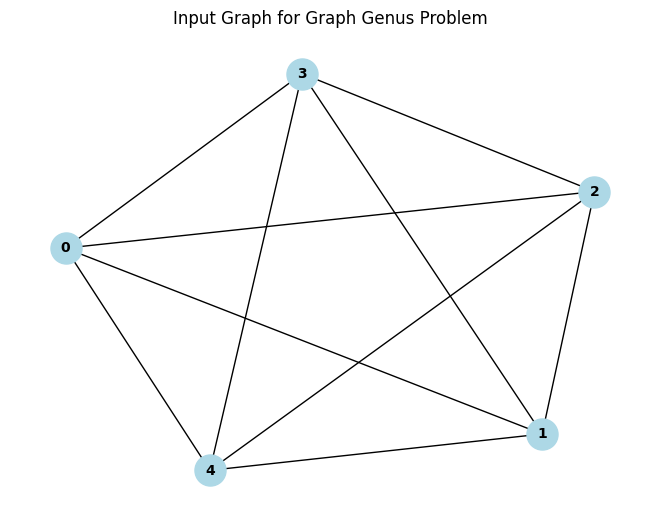

In [6]:
# Get the adjacency list (which is a graph object)
graph = problem.adj_list

# Draw the generated graph
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [7]:
from mlrose_hiive import GeomDecay

sa = SARunner(problem=problem,
              experiment_name='graph_genus_sa',
              output_directory=None,  # specify an output directory to have results saved to disk
              seed=123458,
              iteration_list=2 ** np.arange(11),
              max_attempts=50,
              temperature_list=[0.1],
              decay_list=[GeomDecay])

# the two data frames will contain the results
df_run_stats, df_run_curves = sa.run()